In [1]:
import os
import pandas as pd
import hashlib
import json


def find_images(root, img_extensions = ('.png', '.jpg', '.jpeg')):
    data = []
    for path, directories, files in os.walk(root):
        for file in files:
            if file.lower().endswith(tuple(img_extensions)):
                data.append({'path': os.path.relpath(path, start=root), 'file': file})
    return pd.DataFrame(data)

def create_id(string):
    entity_id = string.apply(lambda x: hashlib.md5(x.encode()).hexdigest()[:16])
    assert len(entity_id.unique()) == len(entity_id)
    return entity_id

# General info

- ID: OS agnostic unique identifier of re-id entity. MD5 hash of unique identifier.
    - MD5 hash of file name is used if it is unique. If not, folder structure is added.
    - ID is OS agnostic -> sort by id makes sense now.
   
- Dataset script from WildMe (BelugaID2022, HyenaID2022, LeopardID2022) follows the same template. Easy to refactor to single function.


### TODO:

- ATRW: Re-download to folders
- Cows 2021: Consistency issues
- WNIGiraffes: Download (190 GB)
- Drosophila: Garbage dataset
- GiraffeZebraID: invalid labels
- HyenaID: one invalid label
- LeopardID: one invalid label
- LionData: Garbage dataset
- StripeSpotter: Consistency issues

# 1. AAUZebraFishID

- Images are from 2 videos from fish tank.
- In each of the video, there are 3 different zebrafish individuals (6 individuals in total). 
    - For each individual zebra fish
        - There is bounding box.
        - Additional features: Right,Turning,Occlusion,Glitch
- Sampling frequency should be about 5 frames, otherwise the difference is way too small.

Number of samples      6672
Number of identitites  6


video  identity
0      1           1086
       2           1086
       3           1086
1      4           1138
       5           1138
       6           1138
Name: id, dtype: int64

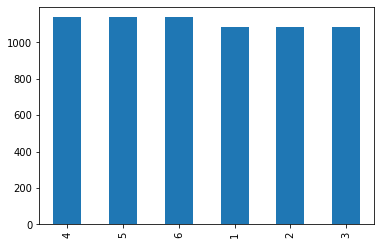

In [74]:
def create_catalogue(root):
    data = pd.read_csv(os.path.join(root, 'annotations.csv'), sep=';')

    columns_bbox = [
        'Upper left corner X',
        'Upper left corner Y',
        'Lower right corner X',
        'Lower right corner Y',
    ]
    bbox = pd.Series(list(data[columns_bbox].to_numpy()))

    attributes = data['Right,Turning,Occlusion,Glitch'].str.split(',', expand=True)
    attributes.columns = ['Right', 'Turning', 'Occlusion', 'Glitch']
    attributes = attributes.astype(bool).to_dict(orient='index')

    video = data['Filename'].str.split('_',  expand=True)[0]
    video = video.astype('category').cat.codes

    df = {
        'id': create_id(data['Object ID'].astype(str) + data['Filename']),
        'path': 'data' + os.path.sep + data['Filename'],
        'identity': data['Object ID'],

        # Optional
        'video': video,
        'bbox': bbox,
        'attributes': attributes,
    }
    return pd.DataFrame(df).sort_values('id').reset_index(drop=True)

root = 'datasets/AAUZebraFishID'
df = create_catalogue(root)

# Statistics
df.identity.value_counts().sort_values(ascending=False).plot(kind = 'bar')
print(f"Number of samples      {len(df)}")
print(f"Number of identitites  {len(df.identity.unique())}")

# Two videos, 6 individual
display(df.groupby(['video', 'identity'])['id'].count())

# 2. AerialCattle2017

- 23 Individual cows, Images are from recorded video footage
- Structure:
    - Individual folder -> Video volder -> Images

Number of samples      46340
Number of identitites  23


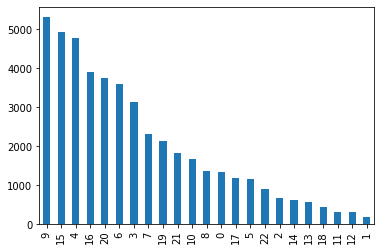

In [77]:
def create_catalogue(root):
    data = find_images(root)
    folders = data['path'].str.split(os.path.sep, expand=True)

    df = {
        'id': create_id(data['file']),
        'path': data['path'] + os.path.sep + data['file'],
        'identity': folders[1].astype(int),

        # Optional        
        'video': folders[2],
    }
    return pd.DataFrame(df).sort_values('id').reset_index(drop=True)

root = 'datasets/AerialCattle2017'
df = create_catalogue(root)

# Per identity counts
df.identity.value_counts().sort_values(ascending=False).plot(kind = 'bar')
print(f"Number of samples      {len(df)}")
print(f"Number of identitites  {len(df.identity.unique())}")

# 3. ATRW

- Two tiers of data

- This dataset needs to be redownloaded with folder names (because of overlapping folders)

In [37]:
root = 'datasets/ATRW'

data = find_images(root)
folders = data['path'].str.split(os.path.sep, expand=True)

id_test = pd.read_csv(os.path.join(root, 'reid_list_test.csv'), header=None)[0]
id_test.sort_values()

263     000000.jpg
601     000004.jpg
1614    000005.jpg
1711    000006.jpg
1337    000008.jpg
           ...    
1657    005122.jpg
1361    005124.jpg
181     005139.jpg
707     005147.jpg
1362    005148.jpg
Name: 0, Length: 1764, dtype: object

# 4. BelugaID

- Folders with Test and Valid are empty, without any data or annotations
- Annotations contains bounding box and segmentations in format [0, 0, XX, YY], indicating that the photos are already cropped.

Number of samples      5902
Number of identitites  788


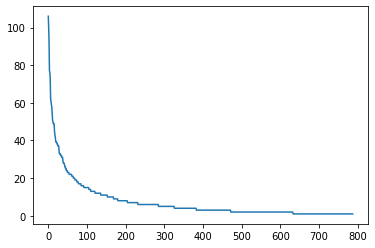

In [79]:
def create_catalogue(root):
    path_json = os.path.join('beluga.coco', 'annotations', 'instances_train2022.json')
    path_images = os.path.join('beluga.coco', 'images', 'train2022')

    # Load annotations JSON file
    with open(os.path.join(root, path_json)) as file:
        data = json.load(file)

    create_dict = lambda i: {'identity': i['name'], 'bbox':i['bbox'], 'image_id': i['image_id']}
    df_annotation = pd.DataFrame([create_dict(i) for i in data['annotations']])

    create_dict = lambda i: {'file_name': i['file_name'], 'image_id':i['id']}
    df_images = pd.DataFrame([create_dict(i) for i in data['images']])

    df = pd.merge(df_annotation, df_images, how='left', on='image_id')
    df['path'] = path_images + os.path.sep + df['file_name']
    df['identity'] = df['identity'].astype('category').cat.codes
    df['id'] = create_id(df['file_name'] + df['identity'].astype(str))

    df = df.drop(['image_id', 'file_name'], axis=1)
    return pd.DataFrame(df).sort_values('id').reset_index(drop=True)

root = 'datasets/BelugaID'
df = create_catalogue(root)

# Per identity counts
df.identity.value_counts().reset_index(drop=True).plot()
print(f"Number of samples      {len(df)}")
print(f"Number of identitites  {len(df.identity.unique())}")

# 5. Cows 2021

- Test and Train folders contain unique identities - open set classification

- This dataset is inconsistent and is hard to determine what are the identities.
- I have no idea what the 'Train' identification dataset is, as there is missing explanation. Identities are mismatched with the 'Test' dataset. (cow 001 in 'Test' != cow 001 in 'Train').


- Test dataset inconsistency: 
    - README:  
        - 181 Identities
        - 13 784 Images
    - FOLDERS: 
        - 181 Identities (Number of folders)
        - 8 670 Images
    - PAPER:  
        - 182 Identities
        - 8 670 Images

In [347]:
root = 'datasets/Cows2021'
data = find_images(root)
folders = data['path'].str.split(os.path.sep, expand=True)

#Select only re-identification dataset
reid = folders[2] == 'Identification'
folders, data = folders[reid], data[reid]

In [348]:
split = folders[3].replace({'Test': 'test', 'Train': 'train'})
assert len(split.unique()) == 2

In [349]:
print('test')
print(len(folders[4][split=='test'].unique()))
print(len(folders[4][split=='test']))

test
181
8670


In [350]:
print('train')
print(len(folders[7][split=='train'].unique()))
print(len(folders[7][split=='train']))

train
301
23350


# 6. C-Tai

- C-Zoo and C-Tai have the same structure.
- Everything seems to be OK

Number of samples      5078
Number of identitites  78


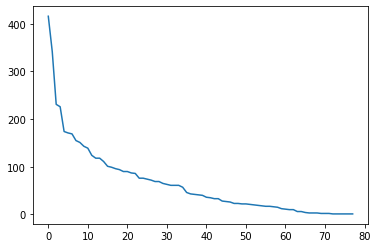

In [116]:
def create_catalogue(root):
    path = os.path.join('chimpanzee_faces-master', 'datasets_cropped_chimpanzee_faces', 'data_CTai',)
    data = pd.read_csv(os.path.join(root, path, 'annotations_ctai.txt'), header=None, sep=' ')

    df = {
        'id': create_id(data[1]),
        'file': path + os.path.sep + data[1],
        'identity': data[3].astype('category').cat.codes,
        
        # Optional
        'name': data[3],
        'age': data[5],
        'age_group': data[7],
        'gender': data[9]
    }
    return pd.DataFrame(df).sort_values('id').reset_index(drop=True)

root = 'datasets/CTai'
df = create_catalogue(root)

# Per identity counts
df.identity.value_counts().reset_index(drop=True).plot()
print(f"Number of samples      {len(df)}")
print(f"Number of identitites  {len(df.identity.unique())}")

# 7. C-Zoo

Number of samples      2109
Number of identitites  24


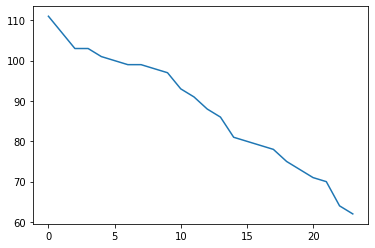

In [69]:
def create_catalogue(root):
    path = os.path.join('chimpanzee_faces-master', 'datasets_cropped_chimpanzee_faces', 'data_CZoo',)
    data = pd.read_csv(os.path.join(root, path, 'annotations_czoo.txt'), header=None, sep=' ')

    df = {
        'id': create_id(data[1]),
        'file': path + os.path.sep + data[1],
        'identity': data[3].astype('category').cat.codes,

        # Optional
        'name': data[3],
        'age': data[5],
        'age_group': data[7],
        'gender': data[9]
    }
    return pd.DataFrame(df).sort_values('id').reset_index(drop=True)

root = 'datasets/CZoo'
df = create_catalogue(root)

# Per identity counts
df.identity.value_counts().reset_index(drop=True).plot()
print(f"Number of samples      {len(df)}")
print(f"Number of identitites  {len(df.identity.unique())}")

# 8. Drosophila

- I have no idea about the structure of the dataset.
- What is train and valid split?  Why are there duplicite file names?
- are the inner folders identities? 
    - Why valid split have images without inner folders? what are their identities?


In [72]:
# This takes a long time
root = 'datasets/Drosophila'
data = find_images(root)
folders = data['path'].str.split(os.path.sep, expand=True)

In [88]:
# This creates unique id
create_id(folders[0] + data['file'])

0          ecbbd236bc9f2dae
1          3f1451d75319abe6
2          a6e6a6a6840dc3e1
3          3b7abacffa5c0100
4          31c7327a50c7c077
                 ...       
2591815    2edbb8c6038a4018
2591816    4e93b71de8e38ddf
2591817    ea1f2757a484cb55
2591818    22adf742cac66dae
2591819    f78f0956a0575328
Length: 2591820, dtype: object

# 9. FriesianCattle2015

- Aerial view of the cows
- Cows are depth segmented

Number of samples      377
Number of identitites  40


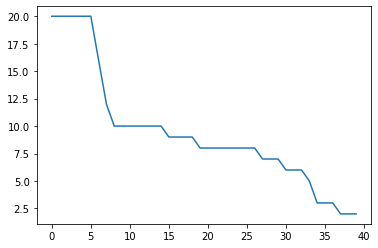

In [42]:
def create_catalogue(root):
    data = find_images(root)
    folders = data['path'].str.split(os.path.sep, expand=True)
    split = folders[1].replace({'Cows-testing': 'test', 'Cows-training': 'train'})
    assert len(split.unique()) == 2

    identity = folders[2].str.strip('Cow').astype(int)

    df = {
        'id': create_id(identity.astype(str) + split + data['file']),
        'path': data['path'] + os.path.sep + data['file'],
        'identity': identity,
        
        # Optional
        'split': split,
    }
    return pd.DataFrame(df).sort_values('id').reset_index(drop=True)

root = 'datasets/FriesianCattle2015'
df = create_catalogue(root)

# Per identity counts
df.identity.value_counts().reset_index(drop=True).plot()
print(f"Number of samples      {len(df)}")
print(f"Number of identitites  {len(df.identity.unique())}")

# 10. FriesianCattle2017

- There are multiple cows in single image. Images are centered such that the given cow identity is at the center.
- Aerial view of the cows as they are in the cow house.

Number of samples      940
Number of identitites  89


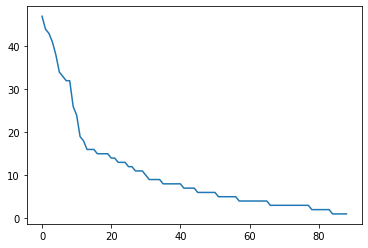

In [41]:
def create_catalogue(root):
    data = find_images(root)
    folders = data['path'].str.split(os.path.sep, expand=True)

    df = {
        'id': create_id(data['file']),
        'path': data['path'] + os.path.sep + data['file'],
        'identity': folders[1].astype(int),
    }
    return pd.DataFrame(df).sort_values('id').reset_index(drop=True)

root = 'datasets/FriesianCattle2017'
df = create_catalogue(root)

# Per identity counts
df.identity.value_counts().reset_index(drop=True).plot()
print(f"Number of samples      {len(df)}")
print(f"Number of identitites  {len(df.identity.unique())}")

# 11. GiraffeZebraID
- WildMe dataset
- There are plenty of mistakes in labeling

In [107]:
def create_catalogue(root):
    path_json = os.path.join('gzgc.coco', 'annotations', 'instances_train2020.json')
    path_images = os.path.join('gzgc.coco', 'images', 'train2020')

    # Load annotations JSON file
    with open(os.path.join(root, path_json)) as file:
        data = json.load(file)

    create_dict = lambda i: {'identity': i['name'], 'bbox':i['bbox'], 'image_id': i['image_id']}
    df_annotation = pd.DataFrame([create_dict(i) for i in data['annotations']])

    create_dict = lambda i: {'file_name': i['file_name'], 'image_id':i['id']}
    df_images = pd.DataFrame([create_dict(i) for i in data['images']])

    df = pd.merge(df_annotation, df_images, how='left', on='image_id')
    df['path'] = path_images + os.path.sep + df['file_name']
    df['identity'] = df['identity'].astype('category').cat.codes
    #df['id'] = create_id(df['file_name'] + df['identity'].astype(str))

    df = df.drop(['image_id', 'file_name'], axis=1)
    #return pd.DataFrame(df).sort_values('id').reset_index(drop=True)
    return df

root = 'datasets/GiraffeZebraID'
df = create_catalogue(root)

In [109]:
# This causes the issue
df[df[['identity', 'path']].duplicated(keep=False)]

,identity,bbox,path
2670,1964,"[573.75, 261.0, 2365.5, 1988.25]",gzgc.coco/images/train2020/000000001863.jpg
2671,1964,"[1410.0, 261.0, 616.5, 1105.5]",gzgc.coco/images/train2020/000000001863.jpg
2872,776,"[848.5, 291.0, 1268.5, 960.0]",gzgc.coco/images/train2020/000000002012.jpg
2874,783,"[1272.5, 111.0, 411.0, 252.5]",gzgc.coco/images/train2020/000000002012.jpg
2875,776,"[870.0, 321.0, 1221.0, 985.5]",gzgc.coco/images/train2020/000000002012.jpg
2876,783,"[1230.0, 81.0, 415.5, 351.0]",gzgc.coco/images/train2020/000000002012.jpg
4792,1,"[382.17703349282294, 812.7990430622009, 461.12...",gzgc.coco/images/train2020/000000003499.jpg
4795,1,"[865.7296650717703, 803.8277511961722, 630.681...",gzgc.coco/images/train2020/000000003499.jpg
5015,452,"[1040.0390625, 843.75, 726.5625, 392.578125]",gzgc.coco/images/train2020/000000003628.jpg
5016,452,"[11.71875, 773.4375, 615.234375, 427.734375]",gzgc.coco/images/train2020/000000003628.jpg


# 12. HappyWhale

- There are lot of identities that have very small number of observation (1 observation)

Number of samples      51033
Number of identitites  15587


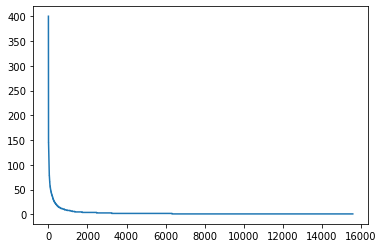

In [113]:
def create_catalogue(root):
    data = pd.read_csv(os.path.join(root, 'train.csv'))

    df = {
        'id': data['image'].str.split('.', expand=True)[0],
        'path': 'train_images' + os.path.sep + data['image'],
        'identity': data['individual_id'].astype('category').cat.codes,

        # Optional
        'species': data['species']
        }
    return pd.DataFrame(df).sort_values('id').reset_index(drop=True)

root = 'datasets/HappyWhale'
df = create_catalogue(root)

# Per identity counts
df.identity.value_counts().reset_index(drop=True).plot()
print(f"Number of samples      {len(df)}")
print(f"Number of identitites  {len(df.identity.unique())}")

# 13. HyenaID2022

- Number of individuals matches dataset description: https://lila.science/datasets/hyena-id-2022/
- There is a mistake in labeling in the dataset: 
    - In photo '000000000207.jpg', there are two hyenas, but in the labels, they share the identity (identity: '74d538f0-cb3e-4982-9584-7e0f886b8397' )

In [76]:
def create_catalogue(root):
    path_json = os.path.join('hyena.coco', 'annotations', 'instances_train2022.json')
    path_images = os.path.join('hyena.coco', 'images', 'train2022')

    # Load annotations JSON file
    with open(os.path.join(root, path_json)) as file:
        data = json.load(file)

    create_dict = lambda i: {'identity': i['name'], 'bbox':i['bbox'], 'image_id': i['image_id']}
    df_annotation = pd.DataFrame([create_dict(i) for i in data['annotations']])

    create_dict = lambda i: {'file_name': i['file_name'], 'image_id':i['id']}
    df_images = pd.DataFrame([create_dict(i) for i in data['images']])

    df = pd.merge(df_annotation, df_images, how='left', on='image_id')
    df['path'] = path_images + os.path.sep + df['file_name']
    df['identity'] = df['identity'].astype('category').cat.codes
    # TODO: df['id'] = create_id(df['file_name'] + df['identity'].astype(str))

    df = df.drop(['image_id', 'file_name'], axis=1)
    # TODO: return pd.DataFrame(df).sort_values('id').reset_index(drop=True)
    return df

# TODO: How to fix the mistake in labeling ? (= identity cannot be uniquely identified)
root = 'datasets/HyenaID2022'
df = create_catalogue(root)

print(f"Number of samples      {len(df)}")
print(f"Number of identitites  {len(df.identity.unique())}")

Number of samples      3129
Number of identitites  256


In [77]:
# This causes the issue
df[df[['identity', 'path']].duplicated(keep=False)]

,identity,bbox,path
208,116,"[774.6575342465753, 888.3561643835616, 545.890...",hyena.coco/images/train2022/000000000207.jpg
209,116,"[945.8904109589041, 652.054794520548, 891.0958...",hyena.coco/images/train2022/000000000207.jpg


# 14. IPanda-50

- There are some crossvalidation splits provided
- They provide facial keypoints annotations.

Number of samples      6874
Number of identitites  50


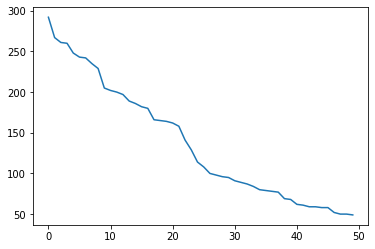

In [166]:
def create_catalogue(root):
    data = find_images(root)
    folders = data['path'].str.split(os.path.sep, expand=True)

    df = {
        'id': create_id(data['file']),
        'path': data['path'] + os.path.sep + data['file'],
        'identity': folders[1].astype('category').cat.codes,

        # Optional
        'name': folders[1],
        }
    return pd.DataFrame(df).sort_values('id').reset_index(drop=True)

root = 'datasets/IPanda-50'
df = create_catalogue(root)

# Per identity counts
df.identity.value_counts().reset_index(drop=True).plot()
print(f"Number of samples      {len(df)}")
print(f"Number of identitites  {len(df.identity.unique())}")

# 15. LeopardID2022

- There is mistake in identity labels:
    - In photo: '000000004590.jpg' there is supposed to be two identities, but there is only one leopard.

In [92]:
def create_catalogue(root):
    path_json = os.path.join('leopard.coco', 'annotations', 'instances_train2022.json')
    path_images = os.path.join('leopard.coco', 'images', 'train2022')

    # Load annotations JSON file
    with open(os.path.join(root, path_json)) as file:
        data = json.load(file)

    create_dict = lambda i: {'identity': i['name'], 'bbox':i['bbox'], 'image_id': i['image_id']}
    df_annotation = pd.DataFrame([create_dict(i) for i in data['annotations']])

    create_dict = lambda i: {'file_name': i['file_name'], 'image_id':i['id']}
    df_images = pd.DataFrame([create_dict(i) for i in data['images']])

    df = pd.merge(df_annotation, df_images, how='left', on='image_id')
    df['path'] = path_images + os.path.sep + df['file_name']
    df['identity'] = df['identity'].astype('category').cat.codes
    # TODO: df['id'] = create_id(df['file_name'] + df['identity'].astype(str))

    df = df.drop(['image_id', 'file_name'], axis=1)
    # TODO: return pd.DataFrame(df).sort_values('id').reset_index(drop=True)
    return df

root = 'datasets/LeopardID2022'
df = create_catalogue(root)

print(f"Number of samples      {len(df)}")
print(f"Number of identitites  {len(df.identity.unique())}")

Number of samples      6825
Number of identitites  431


In [94]:
# This causes the issue
df[df[['identity', 'path']].duplicated(keep=False)]

,identity,bbox,path
4602,58,"[592.5, 141.25, 1266.25, 771.25]",leopard.coco/images/train2022/000000004590.jpg
4603,58,"[682.5, 37.5, 1082.5, 836.25]",leopard.coco/images/train2022/000000004590.jpg


# 16. LionData

- The dataset is very strange - usually, the immage consists of some body parts that are cropped from the images.

In [418]:
def create_catalogue(root):
    data = find_images(root)
    folders = data['path'].str.split(os.path.sep, expand=True)

    identity = folders[3].astype('category').cat.codes
    split = folders[2].replace({'train': 'train', 'val': 'test'})
    assert len(split.unique()) == 2

    df = {
        'id': create_id(data['file']),
        'path': data['path'] + os.path.sep + data['file'],
        'identity': identity,
        
        # Optional
        'split': split
    }
    return pd.DataFrame(df).sort_values('id').reset_index(drop=True)

root = 'datasets/LionData'
df = create_catalogue(root)

Number of samples      740
Number of identitites  94


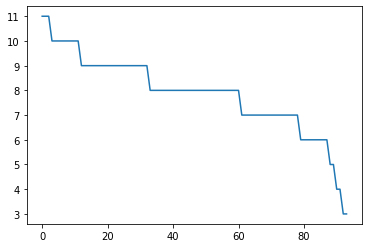

In [419]:
# Per identity counts
df.identity.value_counts().reset_index(drop=True).plot()
print(f"Number of samples      {len(df)}")
print(f"Number of identitites  {len(df.identity.unique())}")

# 17. MacaqueFaces

- Everything seems to be OK

Number of samples      6280
Number of identitites  34


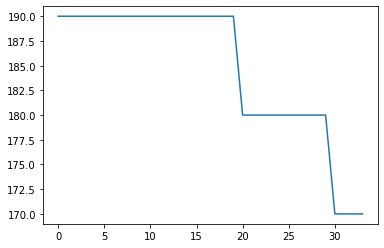

In [141]:
def create_catalogue(root):
    data = pd.read_csv(os.path.join(root, 'MacaqueFaces_ImageInfo.csv'))
    data_files = find_images(root)
    data = pd.merge(data, data_files, how='left', left_on='FileName', right_on='file')

    df = {
        'id': create_id(data['FileName']),
        'path': data['path'] + os.path.sep,
        'identity': data['ID'].astype('category').cat.codes,

        # Optional
        'date': data['DateTaken'],
        'name': data['ID'],
        'category': data['Category'],
    }
    return pd.DataFrame(df).sort_values('id').reset_index(drop=True)


root = 'datasets/MacaqueFaces'
df = create_catalogue(root)

# Per identity counts
df.identity.value_counts().reset_index(drop=True).plot()
print(f"Number of samples      {len(df)}")
print(f"Number of identitites  {len(df.identity.unique())}")

# 18. NyalaData

- Everything seems to be OK

Number of samples      1942
Number of identitites  237


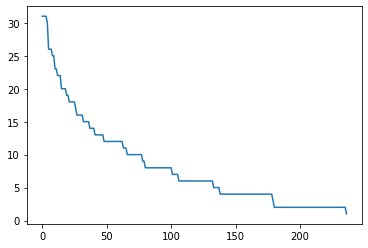

In [140]:
def create_catalogue(root):
    data = find_images(root)
    folders = data['path'].str.split(os.path.sep, expand=True)

    identity = folders[3].astype(int)
    split = folders[2]
    assert len(split.unique()) == 2

    df = {
        'id': create_id(data['file']),
        'path': data['path'] + os.path.sep + data['file'],
        'identity': identity,
        
        # Optional
        'split': split
    }
    return pd.DataFrame(df).sort_values('id').reset_index(drop=True)

root = 'datasets/NyalaData'
df = create_catalogue(root)

# Per identity counts
df.identity.value_counts().reset_index(drop=True).plot()
print(f"Number of samples      {len(df)}")
print(f"Number of identitites  {len(df.identity.unique())}")

# 19. OpenCows2020

- Folder structure includes Train/Test splits (across categories)
- Additionally, they provide some kind of category splits (can it be for open set classification? )
- Subfolder stucture in test and train matches category (identities): test/001 is the same cow as train/001

Number of samples      4736
Number of identitites  46


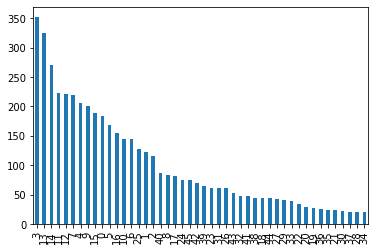

In [568]:
def create_catalogue(root):
    data = find_images(root)
    folders = data['path'].str.split(os.path.sep, expand=True)

    #Select only re-identification dataset
    reid = folders[1] == 'identification'
    folders, data = folders[reid], data[reid]

    split = folders[3]
    assert len(split.unique()) == 2
    identity = folders[4].astype('category').cat.codes

    df = {
        'id': create_id(identity.astype(str) + split + data['file']),
        'path': data['path'] + os.path.sep + data['file'],
        'identity': identity,

        # Optional
        'split': split
    }
    return pd.DataFrame(df).sort_values('id').reset_index(drop=True)

root = 'datasets/OpenCows2020'
df = create_catalogue(root)

# Per identity counts
df.identity.value_counts().sort_values(ascending=False).plot(kind = 'bar')
print(f"Number of samples      {len(df)}")
print(f"Number of identitites  {len(df.identity.unique())}")

# 20. StripeSpotter

- Data are in 3 categories: Original image, downscaled original image, Cropped region of interest (stripes)
    - I filter only full images
- It is unclear how many identities and images are there - 4 images have N/A identity.
    - I would say 821 images and 45 identities

- Exact values are not mentioned in original paper. But it is in follow up papers. For example
    - The dataset is mentioned here: https://arxiv.org/pdf/2005.02905.pdf
    - They claim there is 820 images and 84 identities

In [363]:
def create_catalogue(root):
    data = find_images(root)
    data['index'] = data['file'].str[-7:-4].astype(int)
    category = data['file'].str.split('-', expand=True)[0]
    data = data[category == 'img'] # Only full images
    
    data_aux = pd.read_csv(os.path.join(root, 'data', 'SightingData.csv'))
    data = pd.merge(data, data_aux, how='left', left_on='index', right_on='#imgindex')

    df = {
        'id': create_id(data['file']),
        'path':  data['path'] + os.path.sep + data['file'],
        'identity': data['animal_name']
        #'identity': data['animal_name'].astype('category').cat.codes,

        # Optional
        'bbox': data['roi'].str.split(' '),
        'flank': data['flank'],
        'photo_quality': data['photo_quality'],
    }
    return pd.DataFrame(df).sort_values('id').reset_index(drop=True)

In [372]:
root = 'datasets/StripeSpotter'
df = create_catalogue(root)

In [376]:
# Counts - Images/Identities
print(len(df[df['identity'].notna()]['identity'].unique()))
print(len(df[df['identity'].notna()]['identity']))

45
820


# 21. WhaleSharkID
- Same structure as Beluga, Hyenas and Leopards

Number of samples      7693
Number of identitites  543


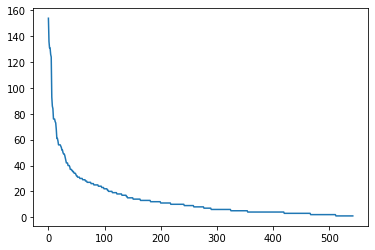

In [40]:
def create_catalogue(root):
    path_json = os.path.join('whaleshark.coco', 'annotations', 'instances_train2020.json')
    path_images = os.path.join('whaleshark.coco', 'images', 'train2020')

    # Load annotations JSON file
    with open(os.path.join(root, path_json)) as file:
        data = json.load(file)

    create_dict = lambda i: {'identity': i['name'], 'bbox':i['bbox'], 'image_id': i['image_id']}
    df_annotation = pd.DataFrame([create_dict(i) for i in data['annotations']])

    create_dict = lambda i: {'file_name': i['file_name'], 'image_id':i['id']}
    df_images = pd.DataFrame([create_dict(i) for i in data['images']])

    df = pd.merge(df_annotation, df_images, how='left', on='image_id')
    df['path'] = path_images + os.path.sep + df['file_name']
    df['identity'] = df['identity'].astype('category').cat.codes
    df['id'] = create_id(df['file_name'] + df['identity'].astype(str))

    df = df.drop(['image_id', 'file_name'], axis=1)
    return pd.DataFrame(df).sort_values('id').reset_index(drop=True)

root = 'datasets/WhaleSharkID'
df = create_catalogue(root)

# Per identity counts
df.identity.value_counts().reset_index(drop=True).plot()
print(f"Number of samples      {len(df)}")
print(f"Number of identitites  {len(df.identity.unique())}")

# 22. WNIGiraffes

- TODO: download first

In [55]:
root = 'datasets/WNIGiraffes'

# 23. ZindiTurtles

- Test dataset does not have labels.

In [12]:
def create_catalogue(root):    

    data_train = pd.read_csv(os.path.join(root, 'train.csv'))
    data_train['source'] = 'train'
    #data_test = pd.read_csv(os.path.join(root, 'test.csv'))
    #data_test['source'] = 'test'
    data_extra = pd.read_csv(os.path.join(root, 'extra_images.csv'))
    data_extra['source'] = 'extra'
    data = pd.concat([data_train, data_extra])
    #data = pd.concat([data_train, data_test, data_extra])

    data = data.reset_index(drop=True)

    df = {
        'id': create_id(data['image_id']),
        'path': 'images' + os.path.sep + data['image_id'] + '.JPG',
        'identity': data['turtle_id'].astype('category').cat.codes,

        # Optional
        'image_location': data['image_location'].str.lower(),
        'source': data['source'],
    }
    return pd.DataFrame(df).sort_values('id').reset_index(drop=True)

root = 'datasets/ZindiTurtleRecall'
df = create_catalogue(root)

Number of samples      12803
Number of identitites  2265


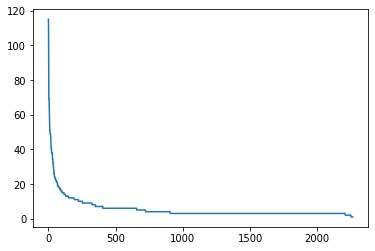

In [13]:
# Per identity counts
df.identity.value_counts().reset_index(drop=True).plot()
print(f"Number of samples      {len(df)}")
print(f"Number of identitites  {len(df.identity.unique())}")

# 